In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import BlackBody
from astropy import units as u
from astropy import constants as const

In [2]:
### FUNCTIONS

def luminosity_bb(T, lambda_1, lambda_2):
    """
    Determines the blackbody flux integrated over some wavelength range

    :param T: the temperature (effective temperature for the star, dayside temperature for the planet) (in Kelvin)
    :type T: float

    :param lambda_1: the lower wavelength bound (in microns)
    :type lambda_1: float

    :param lambda_2: the upper wavelength bound (in microns)
    :type lambda_2: float

    :return: integrated flux
    :rtype: np.array
    """

    bb = BlackBody(temperature=T*u.K)
    wav = np.arange(lambda_1, lambda_2, 0.05) * u.micron
    flux = bb(wav)
    return np.trapezoid(flux)

def phase_planet(t,P,t0=0):
    """
    Determines the phase of a planet at a given time.

    :param t: the time (in days)
    :type t: float

    :param P: the orbital period (in days)
    :type P: float

    :param t0: the reference time (in days)
    :type t0: float

    :return: phase
    :rtype: float
    """

    phase = np.sin(((t+t0)/P)*2*np.pi - np.pi/2)/2+0.5 # equation 15
    return phase

def phase_curve(L_star, L_planet, R_star, R_planet, phase_planet, eclipse, transit_depth, transit):
    """
    Determines the phase curve of a planet from its luminosity, its star's luminosity and its phase function expressed as the ratio between the planet and star's luminosities in ppm.

    :param L_star: the star luminosity (in W)
    :type L_star: float

    :param L_planet: the planet luminosity (in W)
    :type L_planet: float

    :param R_star: the star radius (in m)
    :type R_star: float

    :param R_planet: the planet radius (in m)
    :type R_planet: float

    :param phase_planet: the phase function of the planet
    :type phase_planet: float

    :param eclipse: True if the planet is in eclipse, False otherwise
    :type eclipse: bool

    :return: curve
    :rtype: float
    """
    
    curve = (L_planet/L_star)*phase_planet*(R_planet/R_star)**2 * (-1*eclipse+1) + 1 -transit_depth*transit # *10**6 to have in ppm
    return curve

def transit_depth(R_planet, R_star):
    """
    Determines the depth of an exoplanet transit.

    :param R_planet: the radius of the planet (in m)
    :type Rp: float

    :param R_star: the radius of the star (in m)
    :type R_star: float

    :return: delta_F
    :rtype: float
    """

    delta_F = (R_planet/R_star)**2
    return delta_F

def transit_impact_parameter(a, i, e, R_star, omega):
    """
    Determines the impact parameter of an exoplanet transit.

    :param a: the semimajor axis (in m)
    :type a: float

    :param i: the inclination (in rad)
    :type i: float

    :param e: the eccentricity
    :type e: float

    :param R_star: the radius of the star (in m)
    :type R_star: float

    :param omega: the argument of pericentre (in rad)
    :type omega: float

    :return: b
    :rtype: float
    """

    b = a/R_star * np.cos(i) * (1-e**2)/(1+e*np.sin(omega))
    return b

def eclipse_impact_parameter(a, i, e, R_star, omega):
    """
    Determines the impact parameter of an exoplanet eclipse.

    :param a: the semimajor axis (in m)
    :type a: float

    :param i: the inclination (in rad)
    :type i: float

    :param e: the eccentricity
    :type e: float

    :param R_star: the radius of the star (in m)
    :type R_star: float

    :param omega: the argument of pericentre (in rad)
    :type omega: float

    :return: b
    :rtype: float
    """

    b = a/R_star * np.cos(i) * (1-e**2)/(1-e*np.sin(omega))
    return b

def total_transit_duration(P, a, R_star, R_planet, i, e, omega, b):
    """
    Determines the total duration of an exoplanet transit (in s).

    :param P: the orbital period (in s)
    :type P: float

    :param a: the semimajor axis (in m)
    :type a: float

    :param R_star: the radius of the star (in m)
    :type R_star: float

    :param R_planet: the radius of the planet (in m)
    :type R_planet: float

    :param i: the inclination (in rad)
    :type i: float

    :param e: the eccentricity
    :type e: float

    :param omega: the argument of pericentre (in rad)
    :type omega: float

    :param b: the transit impact parameter
    :type b: float

    :return: t_total
    :rtype: float
    """

    t_total = P/np.pi * np.arcsin(R_star/a * np.sqrt(((1+R_planet/R_star)**2 - (a/R_star * np.cos(i))**2) / (1-np.cos(i)**2)))

    return t_total

def eclipse(P, a, R_star, R_planet, i, phase, e, omega, b, t):
    """
    Determines if an exoplanet is in eclipse or not at a given phase.

    :param P: the orbital period (in s)
    :type P: float

    :param a: the semimajor axis (in m)
    :type a: float

    :param R_star: the radius of the star (in m)
    :type R_star: float

    :param R_planet: the radius of the planet (in m)
    :type R_planet: float

    :param i: the inclination (in rad)
    :type i: float

    :param phase: the phase of the exoplanet (in rad)
    :type phase: function

    :param e: the eccentricity
    :type e: float

    :param omega: the argument of pericentre (in rad)
    :type omega: float

    :param b: the impact parameter
    :type b: float

    :return: in_eclipse
    :rtype: bool
    """

    t_eclipse = total_transit_duration(P, a, R_star, R_planet, i, e, omega, b)

    return phase(t, P) > 1 - phase(t_eclipse/2, P)

def transit(P, a, R_star, R_planet, i, phase, e, omega, b, t):
    """
    Determines if an exoplanet is in transit or not at a given phase.

    :param P: the orbital period (in s)
    :type P: float

    :param a: the semimajor axis (in m)
    :type a: float

    :param R_star: the radius of the star (in m)
    :type R_star: float

    :param R_planet: the radius of the planet (in m)
    :type R_planet: float

    :param i: the inclination (in rad)
    :type i: float

    :param phase: the phase of the exoplanet (in rad)
    :type phase: function

    :param e: the eccentricity
    :type e: float

    :param omega: the argument of pericentre (in rad)
    :type omega: float

    :param b: the impact parameter
    :type b: float

    :return: in_eclipse
    :rtype: bool
    """

    t_eclipse = total_transit_duration(P, a, R_star, R_planet, i, e, omega, b)

    return phase(t, P) < phase(t_eclipse/2, P)

## Temperature of the planet in terms of the temperature of the star and the distance to it

In [3]:
def planet_temperature(T_star, R_star, a, albedo):
    """
    Determines the temperature of the planet assuming circular orbit.
    The albedo is determined by choosing the "type of planet"

    :param T_star: temperature of the star (in K) 
    :type T_star: float

    :param R_star: radius of the star (in m) 
    :type R_star: float

    :param a: the semimajor axis (in m)
    :type a: float

    :param albedo: albedo (dimensionless)
    :type albedo: float

    :return: T_planet
    :rtype: float
    """

    T_planet = T_star * ((R_star / a) ** 0.5) * ((1-albedo) / 4)**0.25

    return T_planet

In [4]:
T_star = 5778
R_star = const.R_sun.value
a = const.au.value
albedo = 0.3
print("The surface temperature of the Sun is", T_star, "K and the surface temperature of the Earth is", planet_temperature(T_star, R_star, a, albedo), "K.")

The surface temperature of the Sun is 5778 K and the surface temperature of the Earth is 254.85041511888895 K.


## First simulation of an atmosphere

In [5]:
def surface_gravity(M_p, R_p):
    """
    Determines surface gravity of the planet (in ms-2)

    :param M_p: mass of the planet (in kg) 
    :type M_p: float

    :param R_p: radius of the planet (in m) 
    :type R_p: float

    :return: g
    :rtype: float
    
    """

    g = const.G.value * M_p / R_p**2

    return g

def scale_height(T_atm, Mm, M_p, R_p):
    """
    Determines the scale height of the atmosphere (in m) 

    :param T_atm: temperature of the atmosphere (in K) 
    :type T_atm: float

    :param Mm: molecular mass (g/mol)
    :type Mm: float

    :param M_p: mass of the planet (in kg) 
    :type M_p: float

    :param R_p: radius of the planet (in m) 
    :type R_p: float

    :return: H
    :rtype: float
    """
    g = surface_gravity(M_p, R_p)
    H = (const.k_B.value * T_atm) / ((Mm/(1000 * const.N_A.value)) * g)

    return H

def surface_number_density(P0, T_atm):
    """
    Determines surface number density with ideal gas law (in m-3)

    :param P0: pressure of the atmosphere (in Pa) 
    :type P0: float

    :param T_atm: temperature of the atmosphere (in K) 
    :type T_atm: float

    :return: n0
    :rtype: float
    """
    n0 = (P0 / (const.k_B.value * T_atm))

    return n0

def absorption_cross_section(centre, width, sigma0, wavelength):
    """
    Determines absorption cross section assuming a gaussian centered at a particular wavelength (in m2) 

    :param centre: central wavelength (in microns) 
    :type centre: float

    :param width: width of the gaussian (dimensionless)
    :type width: float

    :param sigma0: value for the central absorption cross section (in m2)
    :type sigma0: float

    :param wavelength: wavelength (in microns)
    :type width: float
    
    :return: sigma_lambda
    :rtype: float
    """
    sigma_lambda = sigma0 * np.exp(- ((wavelength - centre) / width)**2)

    return sigma_lambda

def altitude_tau_1(sigma_lambda, n0, R_p, H):
    """
    Determines the altitude z where tau is 1 (in m)

    :param sigma_lambda: absorption cross section (m2)
    :type centre: float

    :param n0: surface number density with ideal gas law (in m-3)
    :type width: float

    :param R_p: radius of the planet (in m) 
    :type R_p: float

    :param H: scale height of the atmosphere (in m) 
    :type width: float
    
    :return: z_tau1
    :rtype: float
    """
    
    inside_log = (sigma_lambda * n0 * np.sqrt(2 * np.pi * R_p * H))
    #Important note, if the value inside_log is smaller than one, then the value of altitude_tau_1 would be negative
    #We could study that case separatly and just say that in that case the atmosphere is optically thin and make z=0 for example
    #I am not including that case in this first version. 
    z_tau1 = H * np.log(inside_log)

    return z_tau1

def eff_radius_planet(R_p, z_tau1):
    """
    Determines the effective radius of the planet with atmosphere (in m) 

    :param R_p: radius of the planet (in m) 
    :type R_p: float

    :param z_tau1: the altitude z where tau is 1 (in m) 
    :type z_tau1: float

    :return: R_eff
    :rtype: float
    
    """
    
    R_eff = R_p + z_tau1

    return R_eff
    
def transit_depth_lambda(R_eff, R_star):
    """
    Determines the wavelength-dependent depth of an exoplanet transit.

    :param R_eff: the effective radius of the planet with atmosphere (in m)
    :type Rp: float

    :param R_star: the radius of the star (in m)
    :type R_star: float

    :return: delta_lambda
    :rtype: float
    """

    delta_lambda = (R_eff / R_star)**2
    return delta_lambda

## Density profile in the atmosphere

In [6]:
def density_profile_atm_consT(z, T_atm, Mm, M_p, R_p, P0):
    """
    Determines the density profile (in m-3) of a certain species in the atmosphere based on simple hydrostatic equilibrium + ideal gas law.
    This function assumes constant temperature T(z)=T_atm.

    :param z: height above the surface (in m)
    :type z: float
    
    :param T_atm: temperature of the atmosphere assumed constant (in K) 
    :type T_atm: float

    :param Mm: molecular mass (g/mol)
    :type Mm: float


    :param M_p: mass of the planet (in kg) 
    :type M_p: float

    :param R_p: radius of the planet (in m) 
    :type R_p: float

    :param P0: pressure of the atmosphere (in Pa) 
    :type P0: float

    :return: n
    :rtype: float
    
    """
    H = scale_height(T_atm, Mm, M_p, R_p)
    n0 = surface_number_density(P0, T_atm)

    n = n0 * np.exp(-z/H)

    return n

def density_profile_atm_linearT(z, T_atm_0, Mm, M_p, R_p, P0, constant):
    """
    Determines the density profile (in m-3) of a certain species in the atmosphere based on simple hydrostatic equilibrium + ideal gas law.
    This function assumes a temperature T(z) = T_atm_0 - constant * z. 

    :param T_atm_0: temperature of the atmosphere at the surface (in K) 
    :type T_atm_0: float

    :param Mm: molecular mass (g/mol)
    :type Mm: float

    :param M_p: mass of the planet (in kg) 
    :type M_p: float

    :param R_p: radius of the planet (in m) 
    :type R_p: float

    :param P0: pressure of the atmosphere (in Pa) 
    :type P0: float

    :param constant: constant in the linear expression (in K/m)
    :type constnat: float

    :return: n
    :rtype: float
    
    """

    T = T_atm_0 - constant * z 
    g = surface_gravity(M_p, R_p)
    n0 = surface_number_density(P0, T_atm_0)

    n = (P0 / (const.k_B.value * T)) * (1 - constant * z / T_atm_0) ** ((g * (Mm/(1000 * const.N_A.value))) / (constant * const.k_B.value))

    return n


/tmp/ipykernel_531752/2136584717.py:68: RuntimeWarning: invalid value encountered in power
  n = (P0 / (const.k_B.value * T)) * (1 - constant * z / T_atm_0) ** ((g * (Mm/(1000 * const.N_A.value))) / (constant * const.k_B.value))


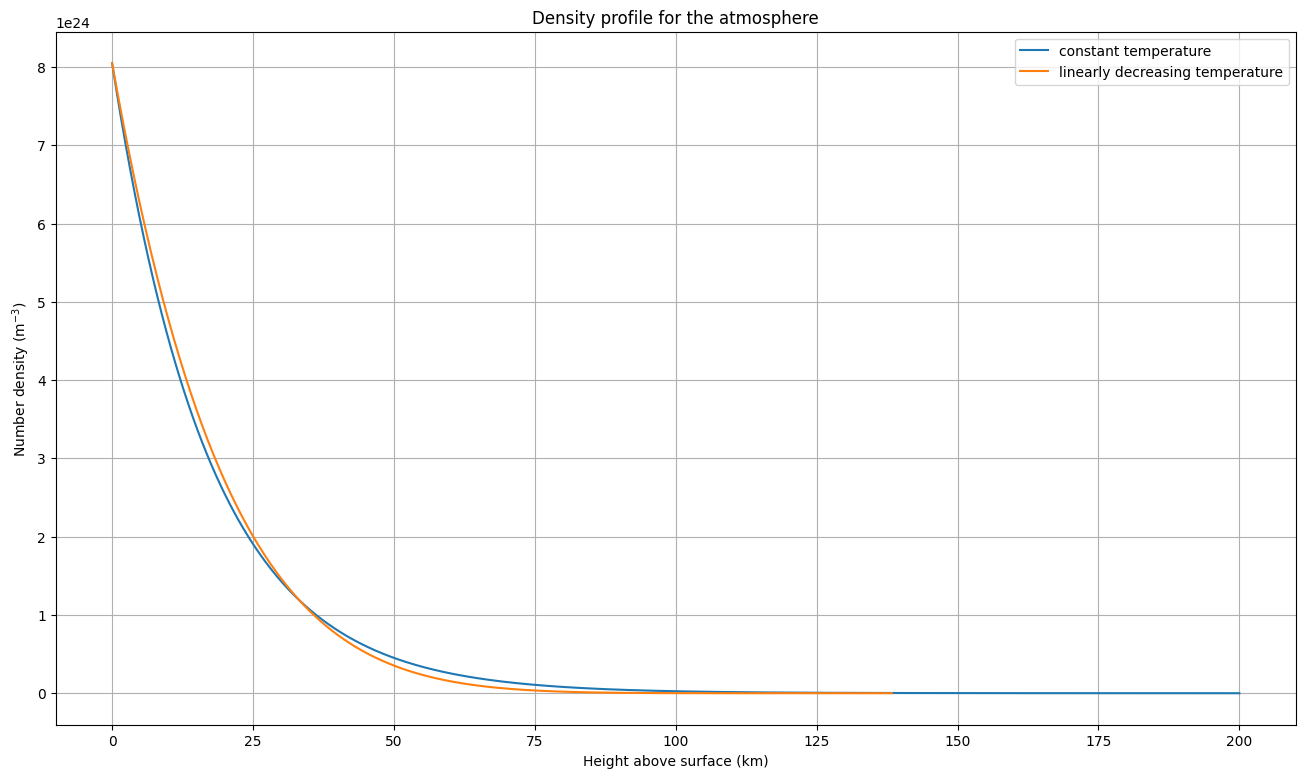

In [7]:
#Test of the density profiles (using data for the WASP-39 b) 
z = np.linspace(0, 200000, num=1000)
T_atm = 900
Mm = 44 
P0 = 1e5  
M_p = const.M_earth.value 
R_p = const.R_earth.value 
constant = 6.5e-3 

plt.figure(figsize=(16,9))
plt.plot(z/1000, density_profile_atm_consT(z, T_atm, Mm, M_p, R_p, P0), label='constant temperature')
plt.plot(z/1000, density_profile_atm_linearT(z, T_atm, Mm, M_p, R_p, P0, constant), label='linearly decreasing temperature')
plt.xlabel("Height above surface (km)")
plt.ylabel("Number density " + r'(m$^{-3}$)')
plt.title("Density profile for the atmosphere")
plt.legend()
plt.grid()
plt.show()


Smooth Transit

In [8]:
def transit_smooth(P, a, R_star, R_planet, i, phase, e, omega, b, t, t_start):
    """
    Gives the fraction of how much the planet is in transit.

    :param P: the orbital period (in s)
    :param a: the semimajor axis (in m)
    :param R_star: the radius of the star (in m)
    :param R_planet: the radius of the planet (in m)
    :param i: the inclination (in rad)
    :param phase: the phase of the exoplanet (in rad)
    :param e: the eccentricity
    :param omega: the argument of pericentre (in rad)
    :param b: the impact parameter
    :t: time array
    :t_start: initial time 

    :return: smooth
    :type smooth: boolean array

    """
    t_full = full_transit_duration(P, a, R_star, R_planet, i, e, omega, b)
    t_total = total_transit_duration(P, a, R_star, R_planet, i, e, omega, b)

    # WRAP t 
    t_rel = ((t - t_start + P / 2) % P) - P / 2 

    t_ingress_start = -t_total / 2
    t_ingress_end = -t_full / 2
    t_egress_start = t_full / 2
    t_egress_end = t_total / 2

    smooth = np.zeros_like(t_rel)

    # Ingress: 
    mask_ingress = (t_rel >= t_ingress_start) & (t_rel <= t_ingress_end)
    smooth[mask_ingress] = (t_rel[mask_ingress] - t_ingress_start) / (t_ingress_end - t_ingress_start)

    # Full transit:
    mask_full = (t_rel > t_ingress_end) & (t_rel < t_egress_start)
    smooth[mask_full] = 1.0

    # Egress:
    mask_egress = (t_rel >= t_egress_start) & (t_rel <= t_egress_end)
    smooth[mask_egress] = 1.0 - (t_rel[mask_egress] - t_egress_start) / (t_egress_end - t_egress_start)

    return smooth
    
def full_transit_duration(P, a, R_star, R_planet, i, e, omega, b):
    """
    Determines the total duration of an exoplanet FULL transit (in s).
    tIII − tII

    :param P: the orbital period (in s)
    :param a: the semimajor axis (in m)
    :param R_star: the radius of the star (in m)
    :type R_star: float
    :param R_planet: the radius of the planet (in m)
    :param i: the inclination (in rad)
    :param e: the eccentricity
    :param omega: the argument of pericentre (in rad)
    :param b: the transit impact parameter
    
    :return: t_total
    :rtype: float
    """

    t_total = P/np.pi * np.arcsin(R_star/a * np.sqrt(((1-R_planet/R_star)**2 - (a/R_star * np.cos(i))**2) / (1-np.cos(i)**2)))

    return t_total

In [28]:
#Parameters of the atmosphere
T_atm = 900.0
Mm = 2.3 # mean molecular weight of WASP-39 b which is mostly composed of H2/He                           
P0 = 1e5  
M_p = 0.28 * const.M_jup.value 
R_p = 1.27 * const.R_jup.value 

#g = surface_gravity(M_p, R_p)
H = scale_height(T_atm, Mm, M_p, R_p)
print(H)
n0 = surface_number_density(P0, T_atm)

centre = 6.0
width = 0.12
sigma0 = 1e-26


756106.0648980312


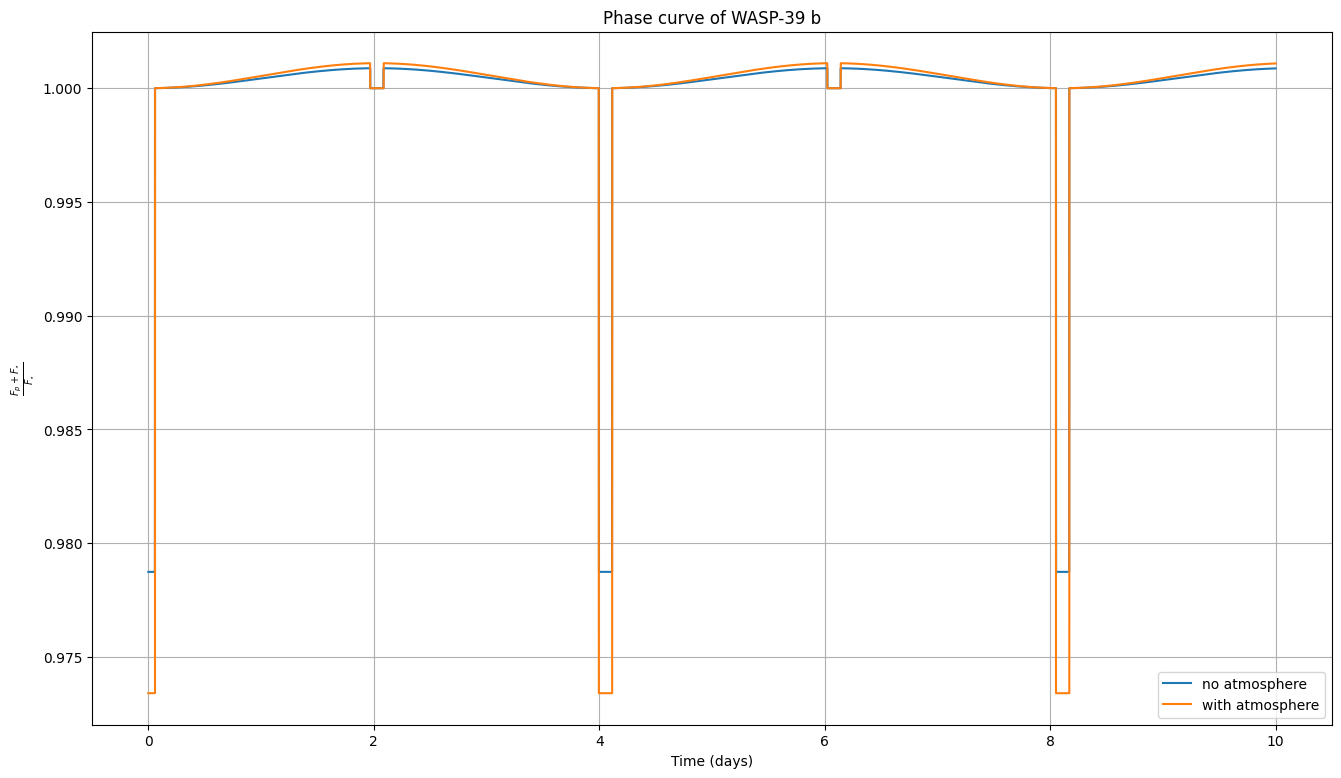

In [29]:
t_start = 0
t_end = 10 # simulation duration in days
nb_points = 10000 # number of points in the time array

t = np.linspace(t_start,t_end,nb_points) # time array in days


# For LHS3844 b, data taken from https://exoplanetarchive.ipac.caltech.edu/overview/LHS%203844%20b#planet_LHS-3844-b_collapsible

e = 0.0
P = 4.055259
omega = 0.0 # bcs e = 0
i = 87.83*np.pi/180
a = 0.0486*149597870700 # a in m
R_star = 0.895*const.R_sun.value
T_star = 5400
T_planet = T_atm
flux_star = BlackBody(T_star*u.K)(5.96*u.micron)
flux_planet = BlackBody(T_planet*u.K)(5.96*u.micron)

#Without atmosphere
phase = phase_planet
b = eclipse_impact_parameter(a,i,e,R_star,omega)
eclipse_bool = eclipse(P,a,R_star,R_p,i,phase,e,omega,b, t)
b = transit_impact_parameter(a,i,e,R_star,omega)
phase_curvee = phase_curve(flux_star,flux_planet,R_star,R_p,phase(t, P),eclipse_bool, transit_depth(R_p, R_star), transit(P, a, R_star, R_p, i, phase, e, omega, b, t))

#With atmosphere

sigma_lambda = absorption_cross_section(centre, width, sigma0, 5.96)
z_tau1 = altitude_tau_1(sigma_lambda, n0, R_p, H)
R_eff = eff_radius_planet(R_p, z_tau1)
delta_lambda = transit_depth_lambda(R_eff, R_star)

b = eclipse_impact_parameter(a,i,e,R_star,omega)
eclipse_bool_atm = eclipse(P,a,R_star,R_eff,i,phase,e,omega,b, t)
b = transit_impact_parameter(a,i,e,R_star,omega)
phase_curve_atm = phase_curve(flux_star,flux_planet,R_star,R_eff,phase(t, P),eclipse_bool_atm, transit_depth_lambda(R_eff, R_star), transit(P, a, R_star, R_eff, i, phase, e, omega, b, t))




plt.figure(figsize=(16,9))
plt.plot(t, phase_curvee, label='no atmosphere')
plt.plot(t, phase_curve_atm, label='with atmosphere')
plt.xlabel("Time (days)")
plt.ylabel(r'$\frac{F_p + F_{\star}}{F_{\star}}$')
plt.title("Phase curve of WASP-39 b")
plt.legend()
plt.grid()
plt.show()

R = R_p

### Test transit_smooth function

t_ingress_start: -0.05855156116162169
t_ingress_end: -0.040452714639286624
t_egress_start: 0.040452714639286624
t_egress_end: 0.05855156116162169
Period: 4.055259


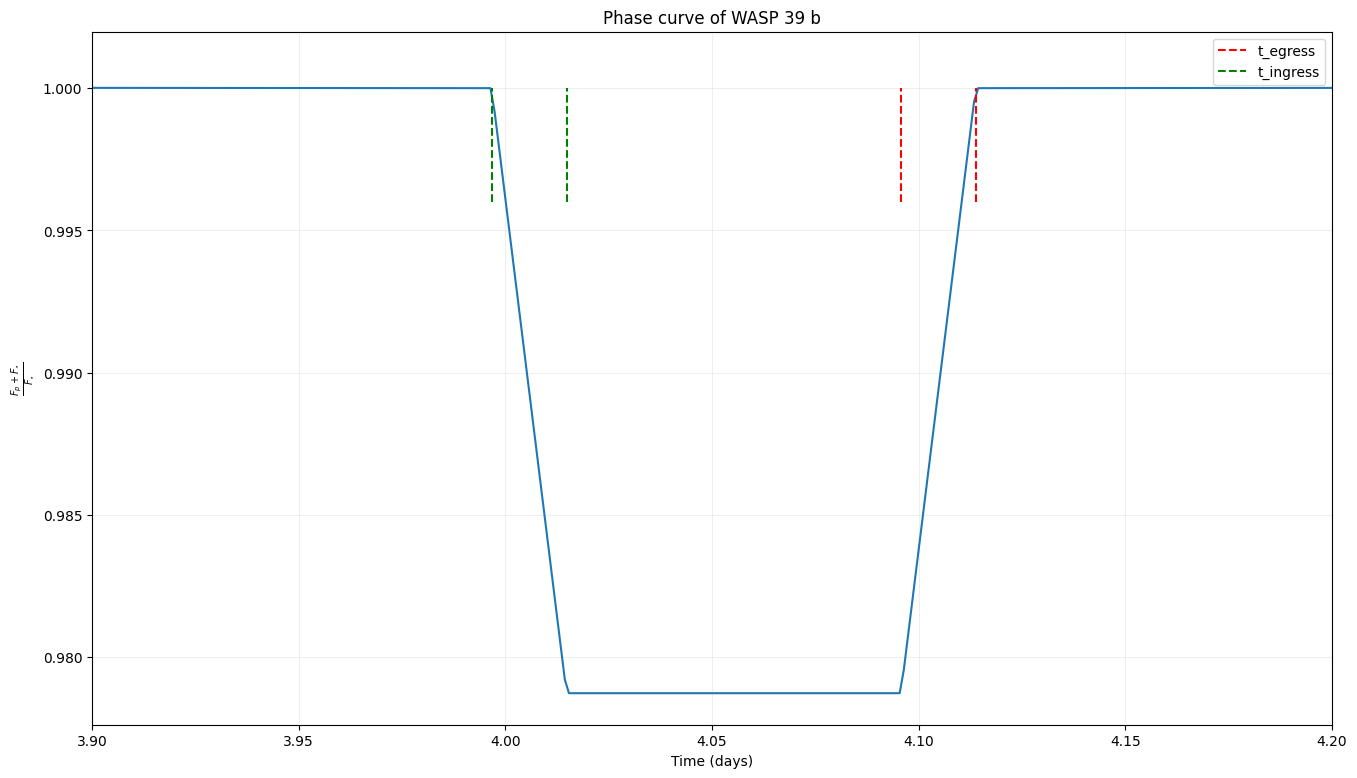

In [30]:
t_full = full_transit_duration(P, a, R_star, R, i, e, omega, b)
t_total = total_transit_duration(P, a, R_star, R, i, e, omega, b)

t_ingress_start = -t_total / 2
t_ingress_end = -t_full / 2
t_egress_start = t_full / 2
t_egress_end = t_total / 2
print("t_ingress_start:", t_ingress_start)
print("t_ingress_end:", t_ingress_end)
print("t_egress_start:", t_egress_start)
print("t_egress_end:", t_egress_end)


print("Period:", P)

t_start = 0
t_end = 10
t = np.linspace(t_start,t_end,nb_points) # time array in days

phase = phase_planet
b = eclipse_impact_parameter(a,i,e,R_star,omega)
eclipse_bool = eclipse(P,a,R_star,R,i,phase,e,omega,b, t)
b = transit_impact_parameter(a,i,e,R_star,omega)
phase_curvee = phase_curve(flux_star,flux_planet,R_star,R,phase(t, P),eclipse_bool, transit_depth(R, R_star), transit_smooth(P, a, R_star, R, i, phase, e, omega, b, t, t_start))


plt.figure(figsize=(16,9))
plt.plot(t, phase_curvee)
plt.plot(np.ones(2)*(t_egress_start + P), [0.996, 1], 'r--', label = "t_egress")
plt.plot(np.ones(2)*(t_egress_end + P), [0.996, 1], 'r--', )

plt.plot(np.ones(2)*(t_ingress_start + P), [0.996, 1], 'g--', label = "t_ingress")
plt.plot(np.ones(2)*(t_ingress_end + P), [0.996, 1], 'g--')

plt.xlabel("Time (days)")
plt.ylabel(r'$\frac{F_p + F_{\star}}{F_{\star}}$')
plt.title("Phase curve of WASP 39 b")

plt.xlim(3.9,4.2)# ZOOM IN

plt.grid(alpha=0.2)
plt.legend()
plt.show()

In [31]:
### molecules/atoms : CO2, H2O, O2, H, He
### gases with little/no greenhouse effect : N2, O2, Ar, Ne, He, H2, CO, O3

### Try 1 : CO2

from hapi import * # pip install hapi

# Create or open a local database directory
db_begin('new_hitran_db')

# Fetch CO2 (molecule 2, isotopologue 1) lines for 4.4 µm region
fetch('CO2_4um', 2, 1, 1800, 3300)   # wavenumbers in cm⁻¹

# The data are stored locally as a table named 'CO2_4um'
# You can load them into a pandas DataFrame:
import pandas as pd
nu, A, elower, g_u, g_l = getColumns('CO2_4um', ['nu', 'A', 'elower', 'gp', 'gpp'])
df = pd.DataFrame({
    'nu': nu,
    'A': A,
    'elower': elower,
    'gp' : g_u,
    'gpp' :g_l
})
print(df.head())


Using new_hitran_db

CO2_4um
                     Lines parsed: 35699

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: CO2_4um
  65536 bytes written to new_hitran_db/CO2_4um.data
  65536 bytes written to new_hitran_db/CO2_4um.data
  65536 bytes written to new_hitran_db/CO2_4um.data
  65536 bytes written to new_hitran_db/CO2_4um.data
  65536 bytes written to new_hitran_db/CO2_4um.data
  65536 bytes written to new_hitran_db/CO2_4um.data
  65536 bytes written to new_hitran_db/CO2_4um.data
  65536 bytes written to new_hitran_db/CO2_4um.data
  65536 bytes written to new_hitran_db/CO2_4um.data
  65536 bytes written to new_hitran_db/CO2_4um.data
  65536 bytes written to new_hitran_db/CO2_4um.data
  65536 bytes written to new_hitran_db/CO2_4um.data
  65536 bytes written to new_hitran_db/CO2_4um.data
  65536 bytes written to new_hitran_db/CO2_4um.data
  65536 bytes written to new_hitran_db/CO2_4um.data
  65536 bytes written to new_hitran_db/CO2_4um.data
  65536 bytes written to new_hitr

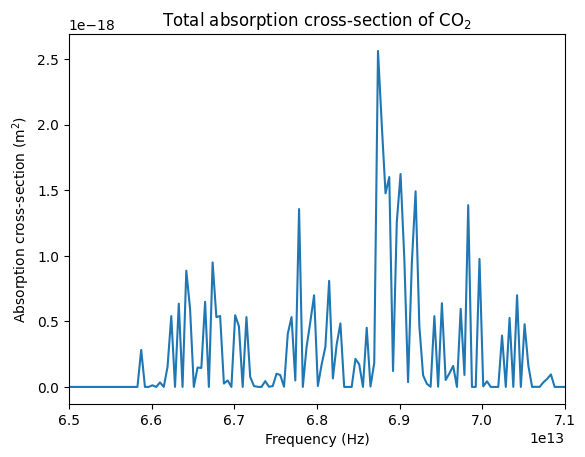

In [32]:
## UNITS : nu = cm-1, A = s-1, elower = cm-1

elower = df['elower'].values*(1/u.cm)
nu = df['nu'].values*(1/u.cm)
eupper = elower + nu
nu = nu.to(u.Hz, equivalencies=u.spectral()) # convert nu in cm-1 to Hz
elower = elower.to(u.J, equivalencies=u.spectral()) # convert energies to J
eupper = eupper.to(u.J, equivalencies=u.spectral())
mu = 44

## computing absorption cross-section

freq_array = np.linspace(const.c.value/(5.5*1e-6), const.c.value/(3.0*1e-6), 1000)
#print(freq_array)
total_absorption_sigma = np.zeros(len(freq_array))

for i in range(len(nu)):
    width = (nu[i].value/const.c.value)*np.sqrt(2*const.k_B.value*T_atm/(mu*const.m_p.value)) # Doppler broadening due to thermal motion of molecules
    sigma0 = 1/(np.sqrt(np.pi)*width)
    gaussian = absorption_cross_section(nu[i].value, width, sigma0, freq_array)
    total_absorption_sigma += (df['gp'][i]/df['gpp'][i])*(const.c.value**2/(8*np.pi*nu[i].value**2))*df['A'][i]*gaussian

plt.figure()
plt.plot(freq_array, total_absorption_sigma)
plt.xlabel(r'Frequency (Hz)')
plt.ylabel(r'Absorption cross-section (m$^2$)')
plt.title(r'Total absorption cross-section of CO$_2$')
plt.xlim(0.65*1e14, 0.71*1e14)
plt.show()

## Computing density n_{i,l}(z) of species in different excitation levels L using Boltzmann distribution and assuming constant temperature in the atmosphere

In [33]:
# Extract both lower and upper levels
levels_lower = pd.DataFrame({
    'E': df['elower'],
    'g': df['gpp'],
    'label': 'lower'
})
levels_upper = pd.DataFrame({
    'E': df['elower'] + df['nu'],
    'g': df['gp'],
    'label': 'upper'
})

# Combine and remove duplicates
levels_all = pd.concat([levels_lower, levels_upper], ignore_index=True)
levels_unique = levels_all.drop_duplicates(subset=['E', 'g']).sort_values(by='E').reset_index(drop=True)

# Convert to joules
#levels_unique['E_J'] = (levels_unique['E'] * (1/u.cm)).to(u.J, equivalencies=u.spectral())
#levels_unique.head()
print(len(levels_unique))
print(len(levels_lower))


39829
35699


In [34]:
E_cm = levels_unique['E'].values*(1/u.cm) 
E_J = E_cm.to(u.J, equivalencies=u.spectral()) 

energy_levels = E_J.value
degeneracies = levels_unique['g'].values

In [35]:
def partition_function(energy_levels, degeneracies, T_atm):
    """
    Determines the value of the partition function of Boltzmann distribution 
    (assuming constant temperature in the atmosphere)
    
    :param energy_levels: retrieved energy levels for the species (in J) 
    :type energy_levels: array

    :param degeneracies: degeneracies of the retrieved levels (dimensionless) 
    :type degeneracies: array

    :param T_atm: temperature of the atmosphere assumed constant (in K) 
    :type T_atm: float
    



    :return: Z
    :rtype: float
    """
    
    M = len(energy_levels)
    Z = 0
    
    for i in range(M):
        Z += degeneracies[i] * np.exp(-energy_levels[i]/(const.k_B.value * T_atm))
    
    return Z

In [36]:
def energy_level_density(energy_level,degeneracy,T_atm, Z, n_tot):
    """
    Determines the density at height z for a certain level given its energy and degeneracy
    (assuming constant temperature in the atmosphere)
    
    :param energy_level: energy level (in J) 
    :type energy_level: float

    :param degeneracy: degeneracy of the level (dimensionless) 
    :type degeneracy: float

    :param T_atm: temperature of the atmosphere assumed constant (in K) 
    :type T_atm: float
    
    :param Z: value of partition function (dimensionless) 
    :type Z: float
    
    :param n_tot: total density at height z (m-3)
    :type n_tot: float
    
    :return: n_level
    :rtype: float
    """
    
    Numerator = degeneracy * np.exp(-energy_level/(const.k_B.value * T_atm))
    P = Numerator / Z
    
    n_level = n_tot * P
    
    return n_level

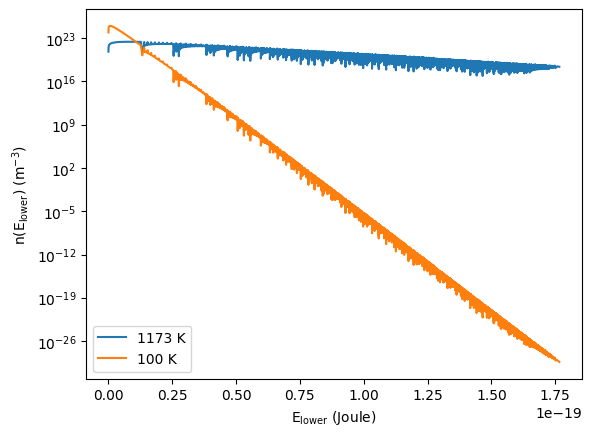

In [37]:
#Test of the density profiles (using data for WASP-39 b) 
z = 100
T_atm = 900 + 273
Mm = 44 # molar mass for CO2
P0 = 1e5  
#M_p = const.M_earth.value 
#R_p = const.R_earth.value 

#We retrieve these two from before (CO2)
energy_levels = E_J.value
degeneracies = levels_unique['g'].values


n_tot = density_profile_atm_consT(z, T_atm, Mm, M_p, R_p, P0)
Z = partition_function(energy_levels, degeneracies, T_atm)

T_2 = 100
n_2 = density_profile_atm_consT(z, T_2, Mm, M_p, R_p, P0)
Z_2 = partition_function(energy_levels, degeneracies, T_2)

n_levels=[]
n_2_tot = []

for i in range(len(energy_levels)):
    n_levels.append(energy_level_density(energy_levels[i],degeneracies[i],T_atm, Z, n_tot))
    n_2_tot.append(energy_level_density(energy_levels[i],degeneracies[i],T_2, Z_2, n_2))

plt.plot(E_J, n_levels, label=f'{T_atm} K')
plt.plot(E_J, n_2_tot, label=f'{T_2} K')
plt.xlabel(r'E$_\mathrm{lower}$ (Joule)')
plt.ylabel(r'n(E$_\mathrm{lower}$) (m$^{-3}$)')
plt.yscale('log')
plt.legend()
plt.show()

In [38]:
print(np.trapezoid(n_levels))
print(np.trapezoid(n_2_tot))

6.162447252372814e+24
7.040238736090621e+25


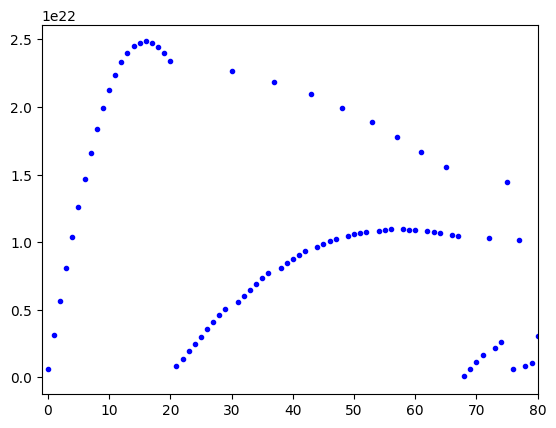

In [39]:
#Plotting the first levels (more populated)
#The beahaviour seem to be the expected, with spikes corresponding to high degeneracy levels
plt.plot(n_levels, 'bo',markersize=3)
plt.xlim(-1,80)
plt.show()

In [40]:
#Checking a bit the shape

print(n_levels[0])
print(n_levels[10])

print(degeneracies[0])
print(degeneracies[10])

print(energy_levels[0])
print(energy_levels[10])

#It seems to make sense with the degeneracies

6.336350842795198e+20
2.124863168162672e+22
1.0
41.0
0.0
3.255157042976235e-21


In [41]:
#Another check 
print(np.sum(n_levels))
print(n_tot)

6.162765193319879e+24
6.162765193319792e+24


## Computing tau

In [43]:
n_CO2 = []
zmax = 2*H # height at which we consider atmosphere to be 0
z = np.arange(0, zmax, 1e3)
for i in range(len(z)):
    n_z = density_profile_atm_consT(z[i], T_atm, Mm, M_p, R_p, P0)
    n_CO2.append(sum(energy_level_density(energy_levels[j],degeneracies [j],T_atm, Z, n_z) for j in range(len(energy_levels))))



In [44]:
n_CO2 = np.array(n_CO2)
delta_nu = []

for i in range(len(total_absorption_sigma)):
    T_nu = []
    for j in range(len(z)):
        tau_nu = total_absorption_sigma[i]*n_CO2[j]*np.sqrt(2*np.pi*(z[j] + R_p)*H) # trusting Lellouch slide 66
        T_nu.append(np.exp(-np.array(tau_nu)))
    T_nu = np.array(T_nu)
    R_eff2 = R_p**2 + 2 * np.trapezoid((1 - T_nu) * (z + R_p), z + R_p)
    delta_nu.append(R_eff2 / R_star**2)
print(len(delta_nu))
print(z + R_p)

1000
[90794840. 90795840. 90796840. ... 92304840. 92305840. 92306840.]


In [45]:
def fast_binning(x, y, bins, error=None, std=False):
    bins = np.arange(np.min(x), np.max(x), bins)
    d = np.digitize(x, bins)

    n = np.max(d) + 2

    binned_x = np.empty(n)
    binned_y = np.empty(n)
    binned_error = np.empty(n)

    binned_x[:] = -np.pi
    binned_y[:] = -np.pi
    binned_error[:] = -np.pi

    for i in range(0, n):
        s = np.where(d == i)
        if len(s[0]) > 0:
            s = s[0]
            binned_y[i] = np.mean(y[s])
            binned_x[i] = np.mean(x[s])
            binned_error[i] = np.std(y[s]) / np.sqrt(len(s))

            if error is not None:
                err = error[s]
                binned_error[i] = np.sqrt(np.sum(np.power(err, 2))) / len(err)
            else:
                binned_error[i] = np.std(y[s]) / np.sqrt(len(s))

    nans = binned_x == -np.pi
    
    return binned_x[~nans], binned_y[~nans], binned_error[~nans]

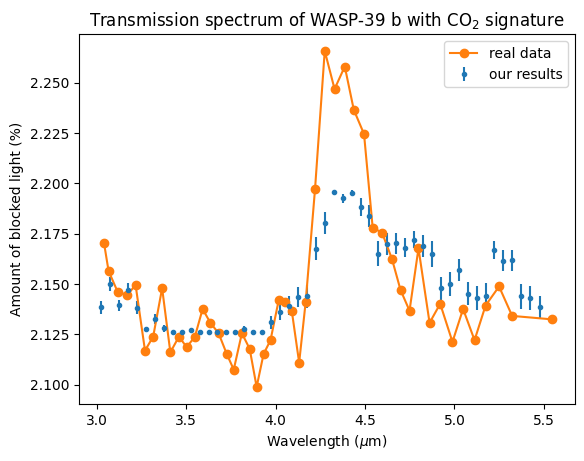

In [46]:
lambda_array = (const.c.value/freq_array)*1e6
y = np.array(delta_nu)*100
binned_data = fast_binning(lambda_array, y, 0.05)
observed_data = pd.read_csv('WASP39b_data.csv')
observed_x = observed_data.iloc[:,0]
observed_y = observed_data.iloc[:,1]

plt.figure()
plt.errorbar(binned_data[0], binned_data[1], binned_data[2], fmt='.', label='our results')
plt.plot(observed_x, observed_y, 'o-', label='real data')
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel('Amount of blocked light (%)')
plt.title(r'Transmission spectrum of WASP-39 b with CO$_2$ signature')
plt.legend()
plt.show()

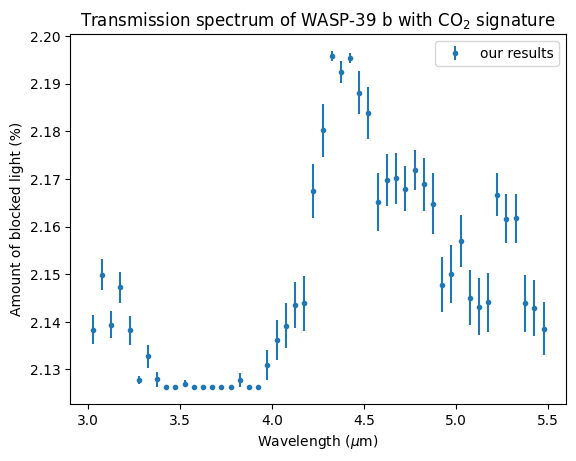

In [47]:
plt.figure()
plt.errorbar(binned_data[0], binned_data[1], binned_data[2], fmt='.', label='our results')
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel('Amount of blocked light (%)')
plt.title(r'Transmission spectrum of WASP-39 b with CO$_2$ signature')
plt.legend()
plt.show()